In [170]:
import sys,os,signal

import numpy as np
import musicnet

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss

from scipy import fft, fftpack
from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score

root = './'

%matplotlib inline

In [171]:
x = np.load("waveform_x.np.npy")

In [172]:
m = 128
k = 100 # number of frequency bins?
d = 4096 # size of windows?
window = 16384 # total number of audio samples?
stride = 512
regions = 1 + (window - d)//stride # number of output after sliding the window through x

# Musicnet Approach

In [173]:
def create_filters(d,k,low=50,high=6000):
    x = np.arange(0, d, 1)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = np.sin(2*np.pi*ind/k*x)
        wcos[ind,0,:] = np.cos(2*np.pi*ind/k*x)
    
    return wsin,wcos

In [174]:
wsin, wcos = create_filters(d,4096)

In [175]:
wsin.shape

(4096, 1, 4096)

In [176]:
wsin_var = Variable(torch.from_numpy(wsin), requires_grad=False)
wcos_var = Variable(torch.from_numpy(wcos),requires_grad=False)

In [177]:
zx = np.sqrt(conv1d(torch.from_numpy(x)[:,None,:], wsin_var, stride=stride).pow(2)+conv1d(torch.from_numpy(x)[:,None,:], wcos_var, stride=stride).pow(2))

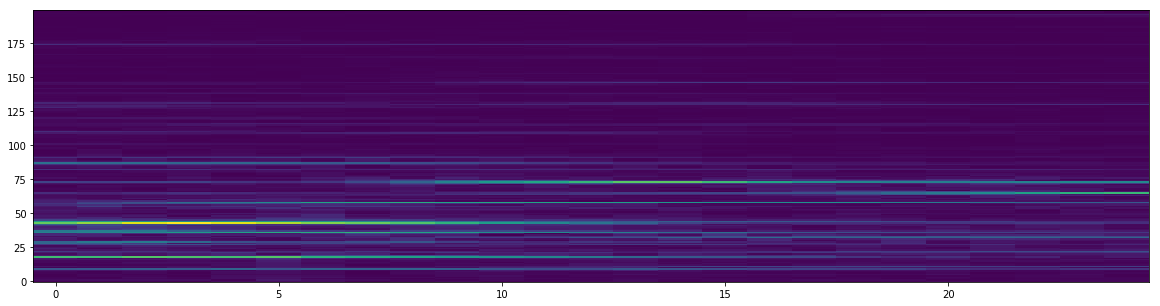

In [182]:
Xs = zx.cpu().numpy()

fig = plt.figure(figsize=(20,5))
plt.imshow(Xs[0][:200],aspect='auto')
plt.gca().invert_yaxis()

# Scipy approach

In [183]:
X_list = []
for i in range(25):
    X_list.append(np.abs(fft(x[0][i*stride:i*stride+d])))

In [184]:
X_list = np.array(X_list)

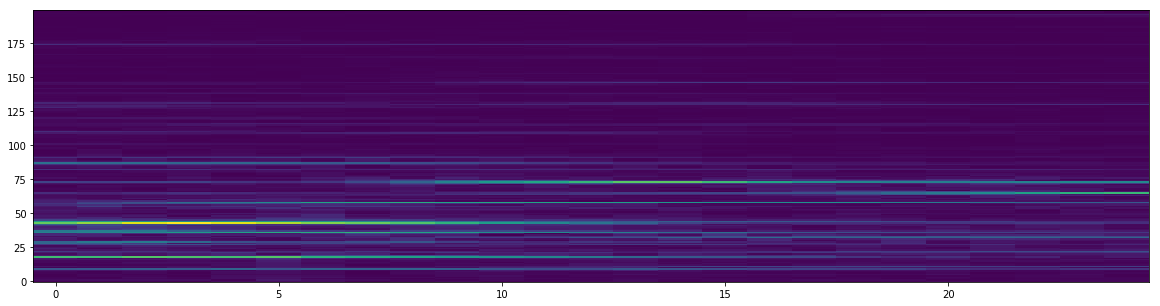

In [185]:
fig = plt.figure(figsize=(20,5))
plt.imshow(X_list.T[:200],aspect='auto')
plt.gca().invert_yaxis()

# Getting only 1 frame

## Conv method

In [186]:
signal_input = torch.from_numpy(x)[:,None,:4096]
 
zx = conv1d(signal_input, wsin_var, stride=stride).pow(2)+conv1d(signal_input, wcos_var, stride=stride).pow(2)

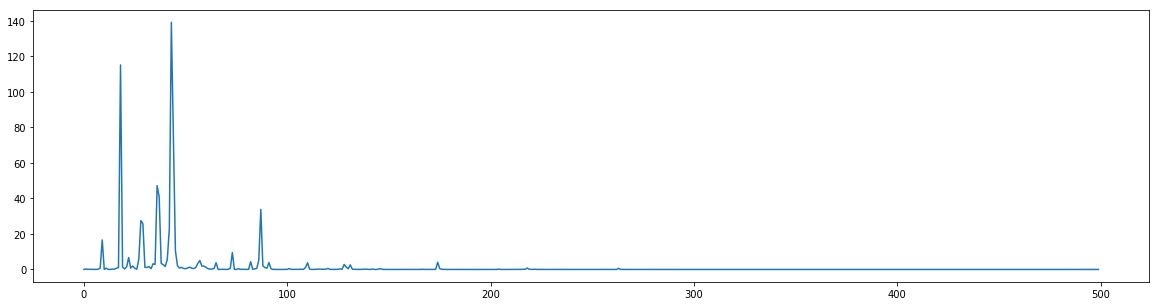

In [187]:
Xs = zx.cpu().numpy()

fig = plt.figure(figsize=(20,5))
plt.plot(Xs[0][:500])

## FFt method

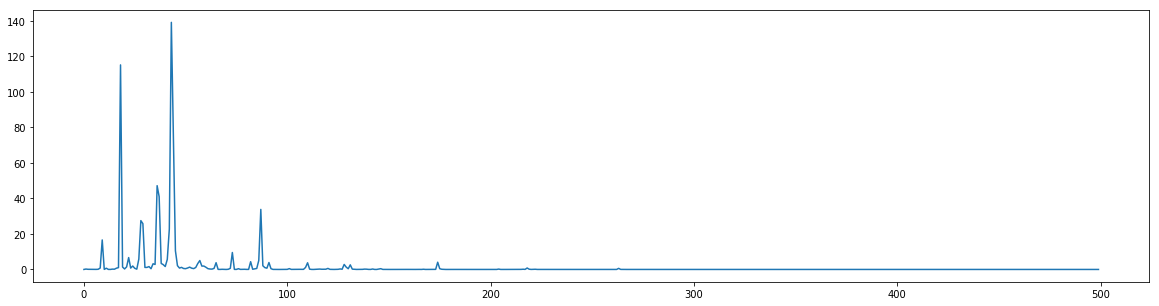

In [194]:
fig = plt.figure(figsize=(20,5))
plt.plot(np.square(np.abs(fft(signal_input[0]).reshape(-1)))[:500])

# Check if they matched each other

In [196]:
a = np.square(np.abs(fft(signal_input[0]).reshape(-1)))

In [197]:
np.allclose(a, Xs[0].reshape(-1),atol=4e-8)

True

# Mel spectrogram study

In [218]:
from librosa.feature import melspectrogram 
from librosa import mel_frequencies
from librosa.core.spectrum import _spectrogram
from librosa.filters import mel

In [235]:
MelS = melspectrogram(y=x[0], sr=44100)

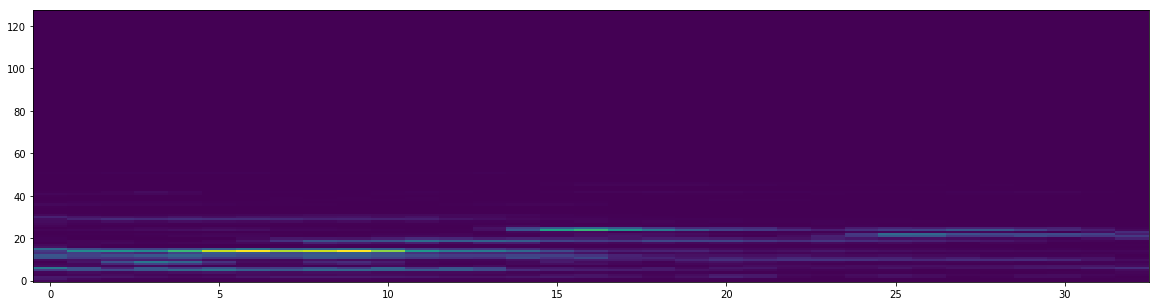

In [236]:
fig = plt.figure(figsize=(20,5))
plt.imshow(MelS,aspect='auto')
plt.gca().invert_yaxis()

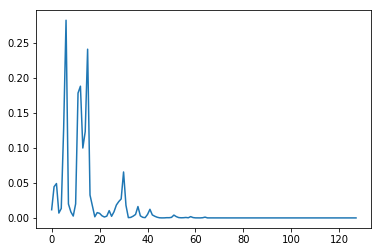

In [237]:
plt.plot(MelS[:,0])

# Step by step

### Getting normal spectrogram by using sftt

In [250]:
S1, n_fft= _spectrogram(x[0],power=1)

In [251]:
mel_basis = mel(44100, n_fft)

In [252]:
S2 = np.dot(mel_basis, S1**2)

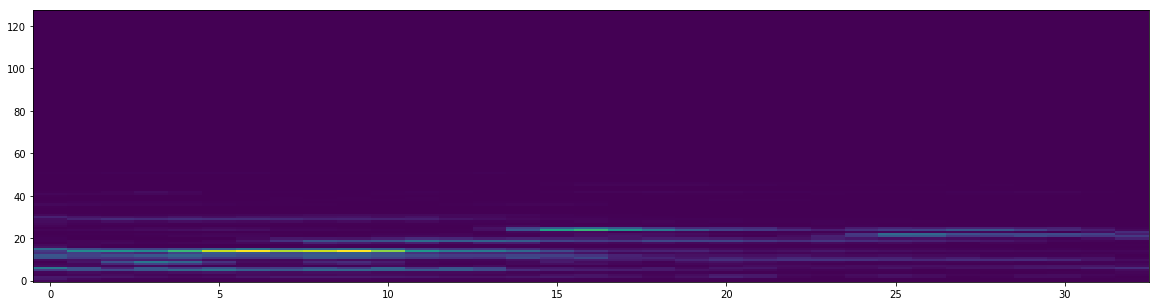

In [253]:
fig = plt.figure(figsize=(20,5))
plt.imshow(S2,aspect='auto')
plt.gca().invert_yaxis()

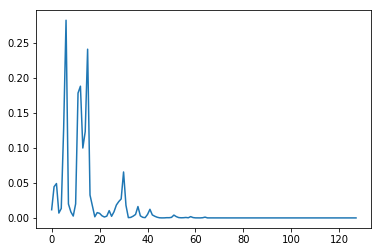

In [254]:
plt.plot(S2[:,0])

# Check if the two stft are the same

In [258]:
np.allclose(S2,MelS)

True